# Building a CNN for Nature Classification

Welcome! The butterfly house next door has approached the botanical garden with a new idea: an app that can classify not just flowers, but also insects and small animals. Your task is to design and build the model that will make this possible.

This problem is more complex than what you’ve tackled before. The linear layers you used previously won’t be enough to capture the rich visual patterns in these diverse images. To meet this new challenge, you’ll build a **Convolutional Neural Network (CNN)**, a model designed to recognize shapes, textures, and features in visual data.

In this lab, you’ll go through the end-to-end process of building a CNN for this classification task. You’ll not only implement the architecture but also follow an iterative workflow—starting with a smaller prototype before scaling up—and learn how to diagnose common training issues.

You will:

* **Prepare a Diverse Dataset**: Load and transform a specialized subset of images for your multi-class nature classifier.

* **Build a CNN Architecture**: Define a complete CNN from scratch, combining convolutional, pooling, and fully connected layers to create a powerful feature extractor.

* **Train a Prototype Model**: Follow a realistic workflow by first training your model on a smaller, 9-class subset to build a working prototype and establish a performance baseline.

* **Scale Up and Diagnose Challenges**: Train the full model on all 15 classes and analyze the results to identify common machine learning challenges like overfitting.

### 1. Library

A **library** is a big collection of code that gives you many ready-made tools.

Example:

* `torch` is a library
* `numpy` is a library

Think of a library as a **toolbox**.

---

### 2. Module

A **module** is a smaller part inside a library that focuses on one job.

Example:

* `torch.utils.data` is a module inside `torch`
* `numpy.linalg` is a module inside `numpy`

Think of a module as a **section inside the toolbox**.

---

### 3. Class

A **class** is a blueprint to create objects.

Example:

* `DataLoader` is a class inside `torch.utils.data`
* `Tensor` is a class in `torch`

Think of a class as a **machine design**.
When you use it, you create an object from it.

---

### Example together:

```python
from torch.utils.data import DataLoader
```

* `torch` → library
* `utils.data` → module
* `DataLoader` → class


## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision.transforms as transforms
# torch.utils.data is a Pytorch module for handling dataset and loading data 
from torch.utils.data import DataLoader

import helper_utils 

In [2]:
# Device configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Preparing the Nature Dataset

For this lab, you'll work with a collection of images taken from the well-known [CIFAR-100 dataset](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR100.html). This dataset is a fantastic resource for computer vision tasks, containing thousands of small, **32x32 color images** that are perfect for training a CNN. It’s a diverse collection, which is exactly what you need for the expanded nature classifier app.

While CIFAR-100 has 100 different classes, you won't need all of them. To meet the new requirements for your app, you'll focus on a curated selection of **15 classes** that fit the theme of a nature classifier. This selection will include flowers, insects and mammals. Specifically, you'll be working with:

* **Flowers**: 'orchid', 'poppy', 'rose', 'sunflower', 'tulip'

* **Mammals**: 'fox', 'porcupine', 'possum', 'raccoon', 'skunk'

* **Insects**: 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'


### Image Transformations

Before you load the dataset, first you need to define the transformation pipelines for it. Since all images in the dataset are already a standard **32x32** size, you don't need to add a resizing step. Your training pipeline will include data augmentation, while both pipelines will convert images to **tensors** and **normalize** them using the standard mean and standard deviation for the CIFAR-100 dataset.

* Define the specific mean and standard deviation for the CIFAR-100 dataset.

In [3]:
# Average pixel values for R, G, B channels.
cifar100_mean = (0.5071, 0.4867, 0.4408)
# Standard deviation for R, G, B channels.                    
cifar100_std = (0.2675, 0.2565, 0.2761)

* Define two separate pipelines using `transforms.Compose`.
    * One for the training set that includes data augmentation and another for the validation set.

## Why these transformations are required 

They are mainly for **data augmentation** and **better training**.

### 1. To increase data artificially

Your dataset is limited.
Transforms like:

* Rotation
* Flip
* Crop

Create new “versions” of the same image.
So model sees more variety without new data.

---

### 2. To reduce overfitting

Without transforms:

* Model memorizes training images
  With transforms:
* Same image looks slightly different each time
* Model learns real features, not exact pixels

---

### 3. To match real-world variations

In real life:

* Camera angle changes
* Face orientation changes
* Lighting changes

Transforms teach model to handle this.

---

### 4. To stabilize training

Normalize:

```python
transforms.Normalize(mean, std)
```

* Makes data centered and balanced
* Training becomes faster and stable

So transforms =
**more data + less overfitting + realistic training + stable learning**.


In [4]:
# Training set transformation pipeline

# transforms.Compose is used to apply multiple transformations in order.
train_transform = transforms.Compose([
# randomly flip the image left <-> right 
    transforms.RandomHorizontalFlip(),
# Randomly rotate the image by an angle between -15° and +15°
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Validation set transformation pipeline
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# we don't apply transformations on validation dataset because they are used to measure real performance , not to train 
# We want original images, no randomness and same input every time 

### Preparing the Data Pipeline

With your transformations ready, it's time to load the data. To quickly show the butterfly house next door a working prototype, it's a smart strategy to start with a smaller, more manageable dataset. This allows you to test your entire pipeline and build a baseline model without the long wait times required for the full dataset.

Therefore, instead of using all 15 classes at once, you'll begin with a balanced subset of **9 classes** (**3 from each category**). This iterative approach is a common and efficient practice in real-world machine learning.

For this initial prototype, you'll use the following classes:

* **Flowers**: 'orchid', 'poppy', 'sunflower'

* **Mammals**: 'fox', 'raccoon', 'skunk'

* **Insects**: 'butterfly', 'caterpillar', 'cockroach'

* Create a Python list containing the names of the 9 classes you'll use for the initial prototype.

In [5]:
subset_target_classes = [
    # Flowers
    'orchid', 'poppy', 'sunflower',
    # Mammals
    'fox', 'raccoon', 'skunk',
    # Insects
    'butterfly', 'caterpillar', 'cockroach'
]

* Use the `load_cifar100_subset` helper function, passing in your `subset_target_classes` list and both transformation pipelines.
* This function handles the entire loading process: it downloads the full CIFAR-100 dataset, applies your specified transformations, and then filters the result to include only the **9 classes** you selected.
* It returns the final training and validation dataset objects, ready for the next step.

In [6]:
# Call the helper function to prepare the datasets
train_dataset_proto, val_dataset_proto = helper_utils.load_cifar100_subset(subset_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.
Dataset loaded successfully.

Filtering for 9 classes...
Filtering complete. Returning training and validation datasets.


* With your `Dataset` objects ready, the final step in the data pipeline is to create `DataLoaders`.

In [7]:
# Set the number of samples to be processes in every batch 
batch_size = 64

# Create a data loader for the training set, with shuffling enabled
train_loader_proto = DataLoader(train_dataset_proto, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set, without shuffling 
val_loader_proto = DataLoader(val_dataset_proto, batch_size=batch_size, shuffle=False)

### Visualizing the Training Images

With your data pipeline complete, it's always a good idea to look at a few examples from your training set. This helps confirm that your data has been loaded and processed correctly. The following helper function will display a random sample of your training images.

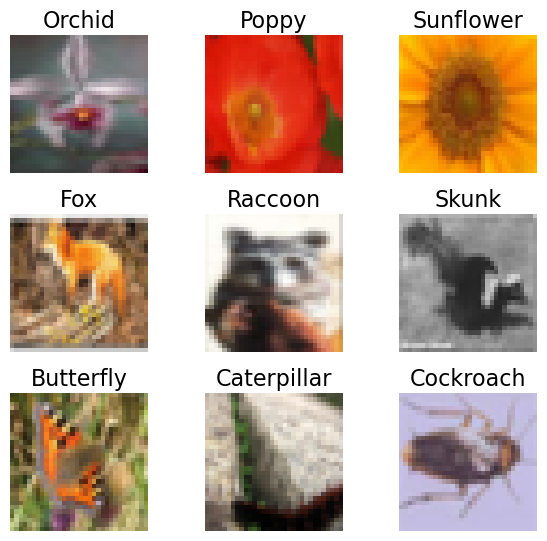

In [8]:
# Visualize a 3x3 grid of random training images
helper_utils.visualise_images(train_dataset_proto, grid=(3,3))

## Building the CNN Architecture

With your data ready, it's time to build the core of your nature classifier. For a complex task like identifying different species in images, the linear layers you've used before aren't enough, as they look at pixels individually without understanding their spatial relationships.

You'll now build a **Convolutional Neural Network (CNN)**, an architecture specifically designed to "see" and recognize patterns, edges, and textures in images through a series of learnable filters. You'll define your model's structure using PyTorch's `nn.Module`, combining several types of layers to create a powerful image classifier.

Here's a breakdown of the key layers you'll use:

**Convolutional Layer (<code>[nn.Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)</code>)**
> This is the core building block of a CNN, using learnable filters to scan the image for visual features. The output is a set of "feature maps" that highlight where in the image these patterns appear.
> * `in_channels`: The number of channels from the previous layer; for the first layer, this is 3 for the RGB color channels.
> * `out_channels`: The number of filters the layer will learn, determining the number of output feature maps.
> * `kernel_size`: The dimensions of the filter, such as a 3x3 grid that examines a pixel and its immediate neighbors.
> * `padding`: Adds a border around the image, allowing the kernel to process edge pixels while preserving the image's dimensions.

Padding means adding extra pixels (usually zeros) around the image before convolution.

Why needed:

Without padding → image size shrinks after every conv

With padding → you can keep size same

**ReLU Activation Function (<code>[nn.ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)</code>)**
> An activation function that introduces non-linearity by changing all negative values in the feature maps to zero. This helps the model learn more complex patterns.

**Max Pooling Layer (<code>[nn.MaxPool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)</code>)**
> This layer downsamples the feature maps by reducing their height and width, which makes the network more efficient. It slides a window over the feature map and keeps only the single largest value from that window, discarding the rest.
> * `kernel_size`: The size of the window to perform pooling on, such as a 2x2 area.
> * `stride`: The step size the window moves across the image. A stride of 2 with a 2x2 kernel will halve the feature map's dimensions.
>
 Max pooling layer:

* Takes a small window (like 2×2)
* Picks the **maximum value**
* Reduces image size

Example:

```python
nn.MaxPool2d(kernel_size=2, stride=2)
```

What it does:

* Height and width become half
* Keeps strongest features
* Removes noise
* Makes model faster and more robust

In simple words:

Max pooling = **downsampling by keeping only the most important signal.**


**Flatten Layer (<code>[nn.Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)</code>)**
> A utility layer that unrolls the 2D feature maps into a single 1D vector. This is a necessary step to prepare the data for the fully connected linear layers.

**Linear Layer (<code>[nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)</code>)**
> Also known as a fully connected layer, it performs the final classification. It combines the features learned by the convolutional layers into a final prediction.

**Dropout Layer (<code>[nn.Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)</code>)**
> A regularization technique that helps prevent overfitting by randomly setting a fraction of neuron activations to zero during training. This forces the network to learn more robust features instead of relying too heavily on any single pattern.

#### How do we decide the value of Padding ?
Rule of thumb:

For kernel size:

3×3 → padding = 1

5×5 → padding = 2

7×7 → padding = 3

padding = (kernel_size - 1) / 2   (when stride = 1 and you want same size)


#### what is the need to divide the convolution block into number of blocks ?

We divide CNN into multiple convolution blocks to **learn features step by step**, from simple to complex.

### Why multiple blocks:

1. Layer-wise learning
   Early blocks learn:

* edges
* corners

Later blocks learn:

* shapes
* object parts

Deep blocks learn:

* full objects

---

2. Gradual abstraction
   Each block transforms raw pixels into higher-level features.

---

3. Control over complexity
   More blocks = more power
   Fewer blocks = simpler model

---

4. Better performance
   Stacking blocks allows:

* More non-linearity
* Better pattern learning

---

5. Practical design
   Each block usually has:

* Conv
* ReLU
* Pool/BN

So blocks are like:

> Levels in a game — each level learns something more advanced.


In [9]:
class SimpleCNN(nn.Module):
    # You are creating your own neural network class called SimpleCNN that is based on PyTorch’s nn.Module.
    """
    A simple Convolution Neural Network model.
    
    The architecture consist of three convolutional blocks followed by two
    fully connected laters for classification.
    """
    # Constructor of our class 
    # __init __ runs automatically when we create the model 
    # self : refers to the current object (our model)
    # num_classes : Numbers of output categories our model must predict 
    def __init__(self, num_classes):
        """
        Initializes the layers of the neural network.
        
        Args:
            num_classes: The number of output classes for the final layer.
        """
        # Call the constructor of the parent class (nn.Module)
        super(SimpleCNN, self).__init__()
        # Call the __init__ method of nn.Module

        # Define the first convolution block 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # kernel_size=2 and stride=2 is the standard choice in nn.MaxPool2d block 
        
        # Define the second convolution block 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the third convolution block 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the layer to flatten the feature maps
        self.flatten = nn.Flatten() 
        # converts the multidimensional data into a 1-D vector

        # Define the fully connected (dense) layers 
        # Input images is 32x32 , after 3 pooling layers: 4x4
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # Takes flattened input of size 128×4×4 ,Outputs 512 features.First , fully connected layer.
        # 512 is a random number we choose , there is no fix choice (hyperparameter) its just that 512 is very commonly used here 
        self.relu4 = nn.ReLU()  # Adds non-linearity 
        self.dropout = nn.Dropout(0.5)  # during training , randomly drops 50% neurons 
        self.fc2 = nn.Linear(512, num_classes)  # final fully connected layer , Converts 512 features into num_classes scores.

    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
          x: The input tensor of shape (batch_size, channels, height, width).
          
          Returns: 
          The output tensor containing the logits for each class.
        """
        # Pass input through the first convolution block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Pass input through the second convolution block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Pass input through the third convolution block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten the output for the fully connected layers      don't remove any comments just fix the intendation 
        x = self.flatten(x)

        # Pass the flattened features through the fully connected layers
        x = self.fc1(x) 
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Return the final output logits 
        return x


Logits = the raw output values of a model before applying an activation like softmax or sigmoid.

With the `SimpleCNN` architecture defined, the next step is to create an instance of the model for your prototype.

* First, dynamically determine the number of output classes by checking the length of the class list in your `train_dataset_proto`.
* Create an instance of your `SimpleCNN`, passing `num_classes` to its constructor.

In [25]:
# Get the number of classes
num_classes = len(train_dataset_proto.classes)
print(num_classes)

# Instantiate the model means to Create an actual object of the model class so you can use it.
prototype_model = SimpleCNN(num_classes)
print(prototype_model)

9
SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)


#### Ceil_mode ??
setting in pool layers (MaxPool) that controls output size calculation.

Before you start training, it's very helpful to visualize how the shape of your data changes as it flows through the CNN. This will confirm that your architecture is set up correctly and show you how the spatial dimensions(the size of data along height and width) shrink while the number of channels grows with each convolutional block.

* Define the `print_data_flow` helper function. 
    * This function will pass a sample 32x32 color image through your model, layer by layer, printing the tensor's shape at each key step to trace its journey from input to final prediction.

In [11]:
def print_data_flow(model):
    """
    Prints the shape of a tensor as it flows through each layer of the model.
    
    Args:
       model : An instance of the Pytorch model to inspect.
    """
    # Create a sample input tensor (batch_size, channels, height, width)
# this line :
    # Creates fake image data 
    # Shape: 1 image, 3 color channels, 32x32 pixels
    # Each pixel value is a random number 
    # Numbers come from a normal distribution 
    # It always generates numbers from a normal distribution with mean = 0 and standard deviation = 1
    
    x = torch.randn(1, 3, 32, 32)

    # Track the tensor shape at each stage 
    print(f"Input shape: \t\t{x.shape}")

    # First conv block 
    x = model.conv1(x)
    print(f"After conv1: \t\t{x.shape}")
    x = model.relu1(x)
    x = model.pool1(x) 
    print(f"After pool1: \t\t{x.shape}")

    # Second conv block 
    x = model.conv2(x)
    print(f"After conv2: \t\t{x.shape}")
    x = model.relu2(x)
    x = model.pool2(x) 
    print(f"After pool2: \t\t{x.shape}")

    # Third conv block 
    x = model.conv3(x)
    print(f"After conv3: \t\t{x.shape}")
    x = model.relu3(x)
    x = model.pool3(x) 
    print(f"After pool3: \t\t{x.shape}")

    # Flatten using the model's flatten layer
    x = model.flatten(x)
    print(f"After flatten : \t\t{x.shape}")

    # Fully connected layers
    x = model.fc1(x)
    print(f"After fc1: \t\t{x.shape}")
    x = model.relu4(x) 
    x = model.dropout(x)
    x = model.fc2(x)
    print(f"Output shape (fc2): \t{x.shape}")

You can now print a summary of your model and trace the data flow to see it in action.

* Call your helper function to print the tensor's shape at each step.

    * The tensor starts as a `(1, 3, 32, 32)` image. As it passes through the `conv` and `pool` blocks, the number of **channels increases** while the **spatial size is halved** at each step.

    * The final `(1, 128, 4, 4)` feature map is **flattened** into a 1D vector to be processed by the linear layers. The model's final **output shape is** `(1, 9)`, providing one score for each of the 9 classes.

In [12]:
# Print the model's architecture 
print(prototype_model)

# Call the helper function to visulize the data flow 
print("\n--- Tracing Data Flow ---")
print_data_flow(prototype_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

--- Tracing Data Flow ---
Input shape: 		torch.Size([1, 3, 32, 32])
After conv1: 		torch.Size([1, 32, 32, 32])
After pool1: 		torch.Size([1, 32, 16, 16])
After conv2: 		torch.Size([1, 64, 16, 16])
After pool2: 		t

## Training the Model

With your model defined and the data pipeline prepared, you're ready to set up the training process. This involves initializing a loss function to measure your model's error and an optimizer to update its weights based on that error.

### Initialize Loss Function and Optimizer

Before starting the training loop, you'll define two key components:

* You'll use <code>[nn.CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)</code>. This is the standard loss function for multi-class classification tasks as it's designed to measure the error when a model has to choose one class from several possibilities.
* You'll use the <code>[Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)</code> optimizer. This is a popular and efficient algorithm that updates the model's weights to minimize the loss.

In [13]:
# Loss function 
loss_function = nn.CrossEntropyLoss()

# Optimizer for the prototype model 
optimizer_prototype = optim.Adam(prototype_model.parameters(), lr=0.001)

### The Training Loop

* Next, you'll define the `training_loop` function. This function encapsulates the entire process of training and validating your model over multiple epochs.

#### What is meant by running loss ?
**Running loss** means:

> The loss value that is being **accumulated and tracked while training is running**.

Example in training loop:

```python
running_loss = 0.0

for i, (inputs, labels) in enumerate(train_loader):
    loss = criterion(outputs, labels)
    running_loss += loss.item()
```

So:

* Each batch gives one `loss`
* `running_loss` keeps adding those losses
* It shows how loss is behaving over time

Used to:

* Monitor training progress
* Print average loss every few batches
* See if model is learning (loss going down)

In simple words:

> Running loss = “current total of losses so far during training.”


#### We have not deined imags and labels anywhere how does it know ?
Because Python creates them **during the loop**.

This line:

```python
for images, labels in train_loader:
```

Means:

* Take one item from `train_loader`
* That item is a pair: `(something1, something2)`
* Put `something1` into variable `images`
* Put `something2` into variable `labels`

So `images` and `labels` are **defined right there**.

They come from:

* Your Dataset’s `__getitem__` method
* Which returns `(image, label)`

So Python doesn’t “know” they are images — it just assigns:

* First value → `images`
* Second value → `labels`


#### What does model.eval() do ?

```python
model.eval()
```

This tells PyTorch:

> “Switch the model to **evaluation mode**.”

It changes behavior of some layers:

* `Dropout` → stops dropping neurons
* `BatchNorm` → uses learned statistics, not batch stats

Used when:

* Testing
* Validation
* Inference

So:

> `model.eval()` makes the model behave like it should during testing, not training.


#### What is running validation loss ?
**Running validation loss** means:

> The loss values being **accumulated while validating** the model over batches.

Example:

```python
running_val_loss = 0.0
for images, labels in val_loader:
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_val_loss += loss.item()
```

So:

* Each batch gives a validation loss
* You keep adding it
* That total is the running validation loss

Used to:

* Track how model performs on unseen data
* Compare with training loss
* Detect overfitting


#### what does this line of code do running_val_loss += val_loss.item() * images.size(0) ?

```python
running_val_loss += val_loss.item() * images.size(0)
```

This does two things:

1. `val_loss.item()`

* Gets the loss value for the **current batch** (as a normal number)

2. `images.size(0)`

* Number of samples in this batch (batch size)

So the line means:

> Add the **total loss of this whole batch** to `running_val_loss`.

Why multiply?

Because:

* `val_loss` is usually the **average loss per sample in the batch**
* To get total loss for that batch:

  ```
  total batch loss = average loss × number of samples
  ```

So this line is:

> “Accumulate true total validation loss across all samples, not just per-batch averages.”


#### What does this line of code do  _, predicted = torch.max(outputs, 1) ?
```python
_, predicted = torch.max(outputs, 1)
```

This line:

* Looks at `outputs` (logits for each class)
* Along dimension `1` (class dimension)
* Finds the **largest value** in each row

`torch.max(outputs, 1)` returns two things:

1. The maximum value
2. The index of that maximum value

You wrote:

```python
_, predicted = torch.max(outputs, 1)
```

So:

* `_` ignores the actual max value
* `predicted` stores the index

That index = predicted class.

In simple words:

> For each image, pick the class with the highest score as the model’s prediction.


In [14]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        loss_function: The loss function to use for training.
        optimizer: The optimization algorithm.
        num_epochs: The total number of epochs to train for.
        device: The device (e.g., 'cpu' or 'cuda') to run the training on.

    Returns:
        A tuple containing:
        - The trained model.
        - A list of metrics [train_losses, val_losses, val_accuracies].
    """
    # Move the model to the specified device (CPU or GPU)
    model.to(device)
    
    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Print a message indicating the start of the training process
    print("--- Training Started ---")
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize running loss for the current epoch
        running_loss = 0.0
        # Iterate over batches of data in the training loader
# takes one batch from train_loader , gets images -> batch of input data and labels -> correct answer
        for images, labels in train_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)
            
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Perform a forward pass to get model outputs
            outputs = model(images)
            # Calculate the loss
            loss = loss_function(outputs, labels)
            # Perform a backward pass to compute gradients
            loss.backward()
            # Update the model parameters
            optimizer.step()
            
            # Accumulate the training loss for the batch
# loss.item() : loss value for one batch (usually average loss per sample)
# images.size(0) : batch size (number of images in that batch)
# loss.item() * images.size(0) : total loss for the whole batch 
# sunning_loss += : add this batch's total loss to everall epoch loss
            running_loss += loss.item() * images.size(0)
            
        # Calculate the average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        # Append the epoch loss to the list of training losses
        train_losses.append(epoch_loss)
        
        # Set the model to evaluation mode
        model.eval()
        # Initialize running validation loss and correct predictions count
        running_val_loss = 0.0
        correct = 0
        total = 0
        # Disable gradient calculations for validation
        with torch.no_grad():
            # Iterate over batches of data in the validation loader
            for images, labels in val_loader:
                # Move images and labels to the specified device
                images, labels = images.to(device), labels.to(device)
                
                # Perform a forward pass to get model outputs
                outputs = model(images)
                
                # Calculate the validation loss for the batch
                val_loss = loss_function(outputs, labels)
                # Accumulate the validation loss
                running_val_loss += val_loss.item() * images.size(0)
                
                # Get the predicted class labels
# For each image , pick the class with the highest score as the model's prediction
                _, predicted = torch.max(outputs, 1)
                # Update the total number of samples
                total += labels.size(0)
                # Update the number of correct predictions
                correct += (predicted == labels).sum().item()
                
        # Calculate the average validation loss for the epoch
# Average validation loss for the epoch means , the mean loss over all validation samples after finishing validation for that epoch
        # running_val_loss = sum of losses of all samples 
        # total_val_samples = number of validation images
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        # Append the epoch validation loss to the list
        val_losses.append(epoch_val_loss)
        
        # Calculate the validation accuracy for the epoch
# The percentage of validation samples the model predicts correctly.
        epoch_accuracy = 100.0 * correct / total
        # Append the epoch accuracy to the list
# After finishing one epoch, take the accuracy you just calculated and add it to a list so you can remember it.
        val_accuracies.append(epoch_accuracy)
        
        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        
    # Print a message indicating the end of the training process
    print("--- Finished Training ---")
    
    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Return the trained model and the collected metrics
    return model, metrics

With all the components in place, you're ready to start training.

* Run the `training_loop` function with your prototype model (for 9 classes), its corresponding data loaders, the loss function, and the optimizer. 
* You'll train for `15 epochs`, and the function will return the trained model along with the collected performance metrics.
* After training is complete, you'll use the `plot_training_metrics` helper function to visualize the training and validation loss, along with the validation accuracy. 

--- Training Started ---
Epoch [1/15], Train Loss: 1.5916, Val Loss: 1.2233, Val Accuracy: 57.67%
Epoch [2/15], Train Loss: 1.2033, Val Loss: 1.0167, Val Accuracy: 65.67%
Epoch [3/15], Train Loss: 1.0396, Val Loss: 0.9418, Val Accuracy: 69.00%
Epoch [4/15], Train Loss: 0.9569, Val Loss: 0.8730, Val Accuracy: 70.89%
Epoch [5/15], Train Loss: 0.8508, Val Loss: 0.7972, Val Accuracy: 72.78%
Epoch [6/15], Train Loss: 0.8307, Val Loss: 0.7609, Val Accuracy: 73.33%
Epoch [7/15], Train Loss: 0.7320, Val Loss: 0.7771, Val Accuracy: 70.56%
Epoch [8/15], Train Loss: 0.7008, Val Loss: 0.7175, Val Accuracy: 75.78%
Epoch [9/15], Train Loss: 0.6357, Val Loss: 0.7376, Val Accuracy: 76.22%
Epoch [10/15], Train Loss: 0.6327, Val Loss: 0.7190, Val Accuracy: 76.44%
Epoch [11/15], Train Loss: 0.5788, Val Loss: 0.6924, Val Accuracy: 76.78%
Epoch [12/15], Train Loss: 0.5364, Val Loss: 0.7309, Val Accuracy: 76.44%
Epoch [13/15], Train Loss: 0.5116, Val Loss: 0.7212, Val Accuracy: 77.67%
Epoch [14/15], Train L

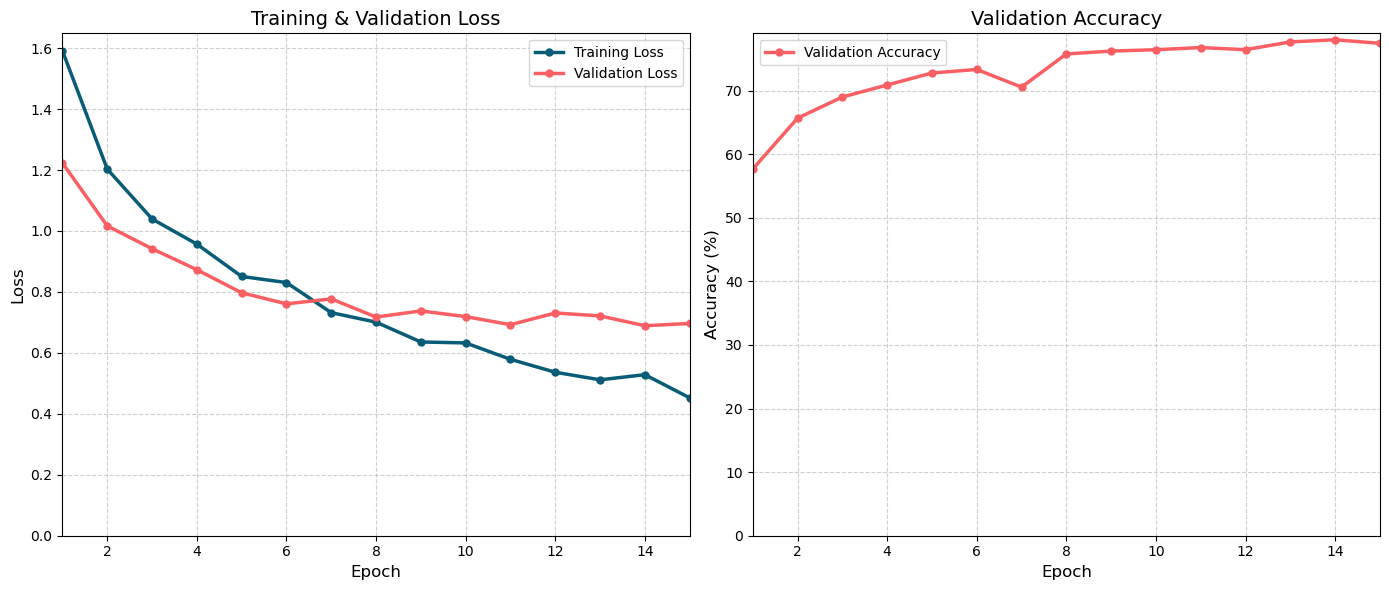

In [15]:
# Start the training process by calling the training loop function

# trained_proto_model = The actual trained neural network , it contains learning weights and biases and can predict new data 
# This is the model after training 

# training_proto_model = Just numbers about training , usually stores training loss per epoch , validation loss per epoch , validation accuracy per epoch 
# This is the training history , not the model 

trained_proto_model, training_metrics_proto = training_loop(
    model=prototype_model, 
    train_loader=train_loader_proto, 
    val_loader=val_loader_proto, 
    loss_function=loss_function, 
    optimizer=optimizer_prototype, 
    num_epochs=15, 
    device=device
)

# Visualize the training metrics (loss and accuracy)
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics_proto)

<br>

Excellent work! The prototype model is trained, and the results look very promising. Achieving a validation accuracy of over **75%** on the 9-class subset is a great result and confirms that your CNN architecture is well-suited for this task.

This successful prototype gives you the green light to move forward with the next phase: training a full-scale model on all 15 classes for the butterfly house. But before you do, it's helpful to perform one last qualitative check to see how your model "thinks."

### Visualizing Predictions

While the plots show your model's overall performance, looking at individual predictions provides a more intuitive feel for its strengths and weaknesses. You can now use a helper function to see your model in action, visualizing its predictions on random images from the validation set. This will show you concrete examples of where it succeeds and where it might be making mistakes.

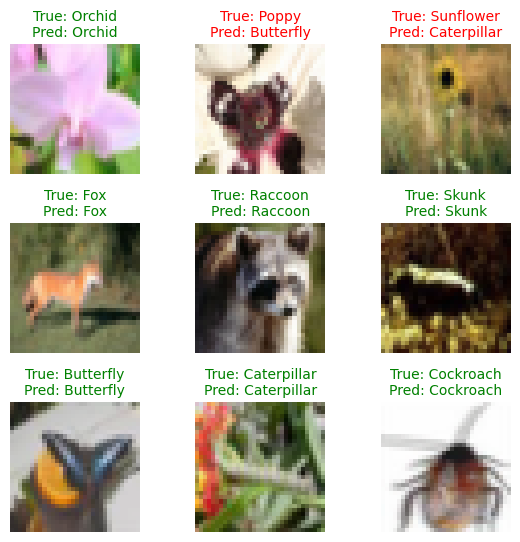

In [16]:
# Visualize model predictions on a sample of validation images
helper_utils.visualise_predictions(
    model=trained_proto_model, 
    data_loader=val_loader_proto, 
    device=device, 
    grid=(3, 3)
)

## Scaling Up: Training the Full Model 

The prototype was a success! Now it's time to train the final model for the butterfly house app. You'll repeat the same steps as before, but this time using the full, more challenging dataset of **15 classes**.

* First, create a new list containing all 15 target classes.
* Use the `load_cifar100_subset` helper function again to create the new training and validation datasets based on this full list.

In [17]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

# Load the full datasets.
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.
Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


<br>

* Wrap your new 15-class datasets in `DataLoader` instances, using the same `batch_size=64`.

In [18]:
# Create a data loader for the training set, with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set, without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

* Display a sample of images from your new 15-class training set to confirm it has been loaded correctly.

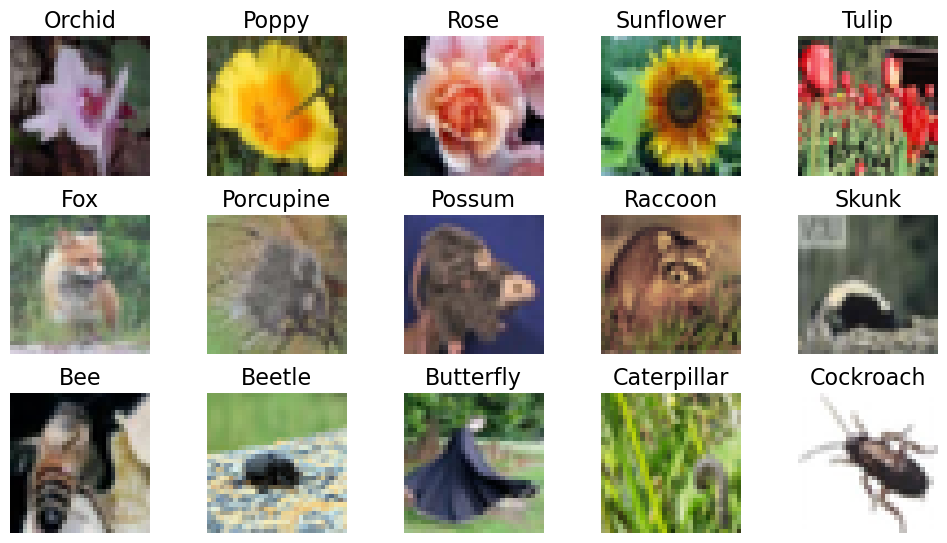

In [19]:
# Visualize a 3x5 grid of random training images
helper_utils.visualise_images(train_dataset, grid=(3, 5))

<br>

* Create a new instance of your `SimpleCNN` model, this time configured for all **15 classes**.

In [20]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the full model
model = SimpleCNN(num_classes)

# Print the model's architecture (notice, it now has 15 output classes)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)


<br>

* Create a new `Adam` optimizer for your full 15-class model.

In [21]:
# Optimizer for the full model 
optimizer = optim.Adam(model.parameters(), lr=0.001)

* Call the `training_loop` to train your 15-class model for `25 epochs`. The `plot_training_metrics` function will then immediately visualize the loss and accuracy curves from this final training run.

--- Training Started ---
Epoch [1/25], Train Loss: 2.2325, Val Loss: 1.7916, Val Accuracy: 38.20%
Epoch [2/25], Train Loss: 1.8145, Val Loss: 1.6471, Val Accuracy: 46.07%
Epoch [3/25], Train Loss: 1.6431, Val Loss: 1.5211, Val Accuracy: 48.33%
Epoch [4/25], Train Loss: 1.5186, Val Loss: 1.3699, Val Accuracy: 54.47%
Epoch [5/25], Train Loss: 1.4140, Val Loss: 1.2728, Val Accuracy: 58.73%
Epoch [6/25], Train Loss: 1.3409, Val Loss: 1.2400, Val Accuracy: 57.00%
Epoch [7/25], Train Loss: 1.2706, Val Loss: 1.2126, Val Accuracy: 58.93%
Epoch [8/25], Train Loss: 1.1976, Val Loss: 1.1921, Val Accuracy: 59.67%
Epoch [9/25], Train Loss: 1.1375, Val Loss: 1.1275, Val Accuracy: 62.27%
Epoch [10/25], Train Loss: 1.0962, Val Loss: 1.1077, Val Accuracy: 61.87%
Epoch [11/25], Train Loss: 1.0298, Val Loss: 1.1386, Val Accuracy: 61.67%
Epoch [12/25], Train Loss: 0.9929, Val Loss: 1.0924, Val Accuracy: 64.13%
Epoch [13/25], Train Loss: 0.9335, Val Loss: 1.0770, Val Accuracy: 65.33%
Epoch [14/25], Train L

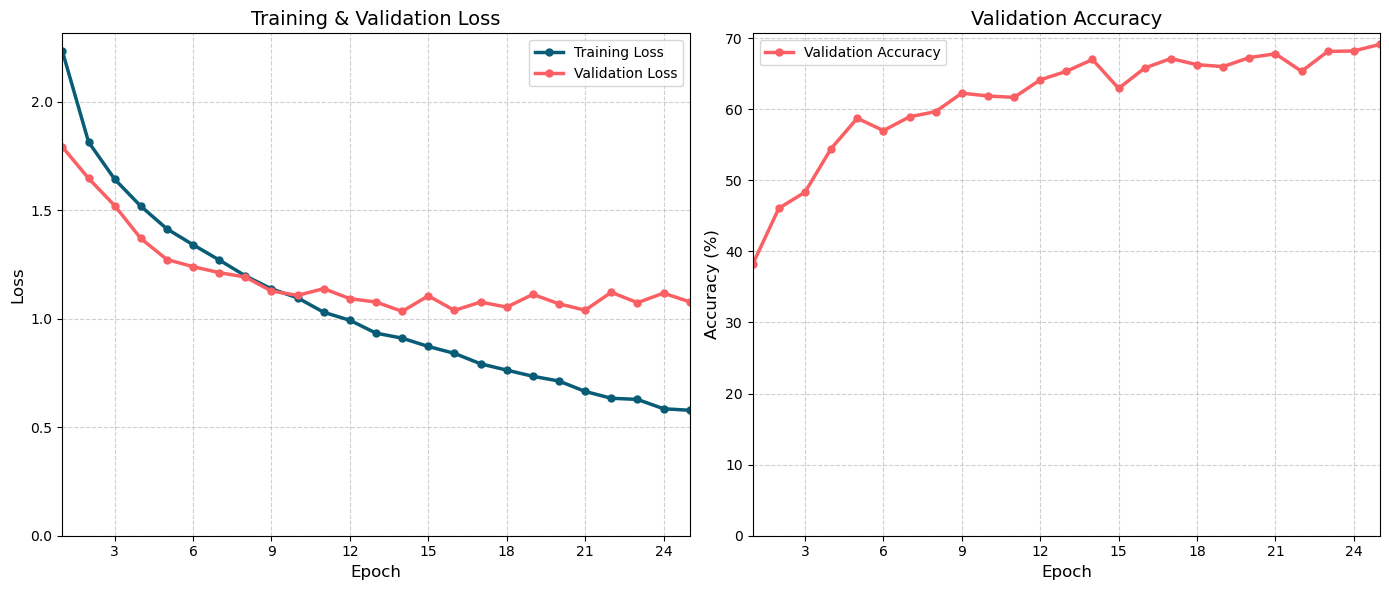

In [22]:
# Start the training process for the full model 
trained_model , training_metrics = training_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    num_epochs=25,
    device=device
)

# Visualize the training metrics for the full model 
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics)

<br>

After training the full model, you can analyze the results. But wait, something isn't right here. Your prototype model trained successfully, showing steady improvement. However, the performance on the full 15-class dataset seems to have hit a wall. What happened?

A close look at the plots reveals the problem. While the **Training Loss** consistently decreases, the **Validation Loss** drops for a while and then begins to rise and fluctuate. At the same time, the **Validation Accuracy** gets stuck, plateauing without making further significant progress. This is a classic case of **overfitting**.

Overfitting occurs when a model learns the training data *too well*, including its noise and specific quirks, instead of the general, underlying patterns that would help it perform on new, unseen data. The widening gap between your training and validation loss is a clear sign your model is memorizing the training set instead of learning to **generalize**.

You might wonder why this happened now and not with the 9-class prototype. The reason is the significant increase in **task complexity**. Distinguishing between 15 classes is much harder than 9, requiring the model to learn more subtle features. Faced with this harder challenge, your powerful CNN model found an easier path to lowering the training loss: it started to memorize the training data instead of learning to generalize.

This overfitting problem presents a realistic challenge, similar to what you'd encounter in a real-world project. In this module's graded assignment, you'll tackle this issue by making several updates to your entire pipeline to see if you can improve the model's ability to generalize.

In [23]:
# ### Optional: Uncomment and run this cell to see the predictions made by the full model

# helper_utils.visualise_predictions(
#     model=trained_model, 
#     data_loader=val_loader, 
#     device=device, 
#     grid=(3, 5)
# )

## Conclusion

Congratulations on completing the lab! You have successfully navigated the entire machine learning pipeline, from data preparation to building, training, and analyzing your very own Convolutional Neural Network.

You've put theory into practice by building a CNN architecture capable of learning complex visual patterns. More importantly, you've experienced a realistic, iterative development workflow by first creating a successful prototype and then scaling up to a more complex model. This process led you to encounter and diagnose overfitting, a fundamental challenge that every machine learning practitioner must learn to solve.

The skills you've developed here have prepared you for the next step. You've identified the problem, and in the graded assignment, you'll get to solve it. Well done!